# Data Downtime Challenge | Exercise 2

## 0. Setup

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
import sys
sys.path.append("..")

In [4]:
from data.utils.exercise_2 import all_days, show_reports

In [5]:
import sqlite3

conn = sqlite3.connect("../data/dbs/Ex2.db")
c = conn.cursor()

## 1. Introduction

In the last exercise, we examined some isolated data downtime incidents in the `EXOPLANETS` table. While the techniques from that exercise are helpful, in practice data downtime involves data infrastructure where many tables interact. So, in this exercise, we'll look at a scenario where multiple tables interact.

### `EXOPLANETS`
Let's once again consider our `EXOPLANETS` table, but at a later date than before. Now, our table has additional entries and additional _fields_. We now record the planets' orbital eccentricity and the contents of their atmosphere.

In [6]:
c.execute("PRAGMA table_info(EXOPLANETS);")
c.fetchall()

[(0, '_id', 'TEXT', 0, None, 0),
 (1, 'distance', 'REAL', 0, None, 0),
 (2, 'g', 'REAL', 0, None, 0),
 (3, 'orbital_period', 'REAL', 0, None, 0),
 (4, 'avg_temp', 'REAL', 0, None, 0),
 (5, 'date_added', 'TEXT', 0, None, 0),
 (6, 'eccentricity', 'REAL', 0, None, 0),
 (7, 'atmosphere', 'TEXT', 0, None, 0)]


Let's take a look at our 10 most recent additions to the table:

In [7]:
pd.read_sql_query("SELECT * FROM EXOPLANETS ORDER BY DATE_ADDED DESC LIMIT 10", conn)

,_id,distance,g,orbital_period,avg_temp,date_added,eccentricity,atmosphere
0,ccb3e5ac-e442-4b97-8598-e965a3979e27,30.413412,2.106487,NaN,NaN,2020-09-06,0.815541,None
1,69e03917-8ebc-4b6f-929f-389a72d0e7d0,2.583353,12.877323,733.287401,244.284192,2020-09-06,0.014063,None
2,d8ca05cd-d51b-45a4-87fa-77953b4a39bb,28.426913,1.957029,NaN,308.557738,2020-09-06,0.439174,None
3,a3002dd8-c0a4-4f02-9636-3726a1dca0e9,90.387710,2.689654,605.644729,NaN,2020-09-06,0.830666,None
4,bed5289e-5547-44b9-8f08-7b1f0938ad6d,74.619784,4.414655,107.945782,NaN,2020-09-06,NaN,H2SO4
5,e4cf3038-95b5-47be-bf98-c0b3433d5df6,26.600994,6.554648,570.518311,379.928077,2020-09-06,0.042601,None
6,7b757b6a-7c30-40a9-83df-35016e31b93f,65.675008,3.777415,704.465275,318.733111,2020-09-06,NaN,O2
7,7123cbf9-ffc2-41cc-b7e9-de617267146c,95.138922,7.511761,NaN,NaN,2020-09-06,0.179230,None
8,221aa90c-5d92-4b3e-8a01-f05b43e5f229,76.562854,11.100272,NaN,207.902495,2020-09-06,0.899648,None
9,02b4c524-6ef6-44cc-a18b-894e5ac0f62c,81.743991,3.439940,597.429313,NaN,2020-09-06,0.855455,None


A database entry in `EXOPLANETS` contains the following info:

0. `_id`: A UUID corresponding to the planet.
1. `distance`: Distance from Earth, in lightyears.
2. `g`: Surface gravity as a multiple of $g$, the gravitational force constant.
3. `orbital_period`: Length of a single orbital cycle in days.
4. `avg_temp`: Average surface temperature in degrees Kelvin.
5. `date_added`: The date our system discovered the planet and added it automatically to our databases.
6. `eccentricity`: The [orbital eccentricity](https://en.wikipedia.org/wiki/Orbital_eccentricity) of the planet about its host star.
7. `atmosphere`: The dominant chemical makeup of the planet's atmosphere.

Note that like `distance`, `g`, `orbital_period`, and `avg_temp`, both `eccentricity` and `atmosphere` may be `NULL` for a given planet as a result of missing or erroneous data. For example, [rogue planets](https://en.wikipedia.org/wiki/Rogue_planet) have undefined orbital eccentricity, and many planets don't have atmospheres at all.

Note also that data is not backfilled, meaning data entries from the beginning of the table will not have `eccentricity` and `atmosphere` information.

In [8]:
pd.read_sql_query(
    """
        SELECT
            date_added,
            eccentricity,
            atmosphere
        FROM EXOPLANETS
        ORDER BY DATE_ADDED ASC
        LIMIT 10
    """,
    conn
)

,date_added,eccentricity,atmosphere
0,2020-01-01,None,None
1,2020-01-01,None,None
2,2020-01-01,None,None
3,2020-01-01,None,None
4,2020-01-01,None,None
5,2020-01-01,None,None
6,2020-01-01,None,None
7,2020-01-01,None,None
8,2020-01-01,None,None
9,2020-01-01,None,None


### `EXOPLANETS_SCHEMA`

Thankfully, we have been recording historical `table_info` on the `EXOPLANETS` table and collecting the results in a table called `EXOPLANETS_SCHEMA`, updated daily.

In [9]:
c.execute("PRAGMA table_info(EXOPLANETS_SCHEMA);")
c.fetchall()

[(0, 'date', 'TEXT', 0, None, 0), (1, 'schema', 'TEXT', 0, None, 0)]

Querying the very beginning and end of `EXOPLANETS_SCHEMA`'s data reflects that `EXOPLANETS`'s metadata has changed since January 2020:

In [10]:
exoplanets_schema_df = pd.read_sql_query("SELECT * FROM EXOPLANETS_SCHEMA", conn)
print("Was:    " + exoplanets_schema_df.iloc[0]["schema"])
print("Is now: " + exoplanets_schema_df.iloc[-1]["schema"])

Was:    [
    (0, '_id', 'TEXT', 0, None, 0),
    (1, 'distance', 'REAL', 0, None, 0),
    (2, 'g', 'REAL', 0, None, 0),
    (3, 'orbital_period', 'REAL', 0, None, 0),
    (4, 'avg_temp', 'REAL', 0, None, 0),
    (5, 'date_added', 'TEXT', 0, None, 0)
  ]
Is now: [
    (0, '_id', 'TEXT', 0, None, 0),
    (1, 'distance', 'REAL', 0, None, 0),
    (2, 'g', 'REAL', 0, None, 0),
    (3, 'orbital_period', 'REAL', 0, None, 0),
    (4, 'avg_temp', 'REAL', 0, None, 0),
    (5, 'date_added', 'TEXT', 0, None, 0),
    (6, 'eccentricity', 'REAL', 0, None, 0),
    (7, 'atmosphere', 'TEXT', 0, None, 0)
  ]


## 2. Exercise: Understanding **Schema Change**

When exactly did `EXOPLANETS` start recording new data? The metadata in `EXOPLANETS_SCHEMA` should tell us. See if you can write a SQL query that returns the date(s) the schema changed and to what it changed.

- *Hint*: As before, `solutions/exercise_2.ipynb` is your friend if you need inspiration.

In [11]:
# YOUR CODE HERE
SQL = """
WITH CHANGES AS(
    SELECT
        date,
        schema AS new_schema,
        LAG(schema) OVER(ORDER BY date) AS past_schema
    FROM
        EXOPLANETS_SCHEMA
)
SELECT
    *
FROM
    CHANGES
WHERE
    new_schema != past_schema
ORDER BY
    date ASC
"""
# END YOUR CODE

In [12]:
schema_changes = pd.read_sql_query(SQL, conn)
schema_changes = schema_changes \
    .rename(columns={clmn: clmn.lower() for clmn in schema_changes.columns})
schema_changes

,date,new_schema,past_schema
0,2020-07-19,"[\n (0, '_id', 'TEXT', 0, None, 0),\n (1...","[\n (0, '_id', 'TEXT', 0, None, 0),\n (1..."


A correct implementation should show a single date, **2020-07-19**. Since the data was not backfilled, we can also arrive at this result implicitly, by checking the rate of non-null `eccentricity` and `atmosphere` values in `EXOPLANETS` over time.

In [13]:
SQL = """
SELECT
    DATE_ADDED,
    SUM(CASE WHEN ECCENTRICITY IS NULL THEN 0 ELSE 1 END) AS ECCENTRICITY_COUNT_ADDED,
    SUM(CASE WHEN ATMOSPHERE IS NULL THEN 0 ELSE 1 END) AS ATMOSPHERE_COUNT_ADDED 
FROM
    EXOPLANETS
GROUP BY
    DATE_ADDED
"""

In [14]:
count_added = pd.read_sql_query(SQL, conn)
count_added = count_added \
    .rename(columns={clmn: clmn.lower() for clmn in count_added.columns})
count_added = count_added.set_index("date_added")

These plots show the number of new entries with values for `eccentricity` and `atmosphere` respectively on each day. Note that on July 19, entries abruptly start filling in because of the addition to the schema.

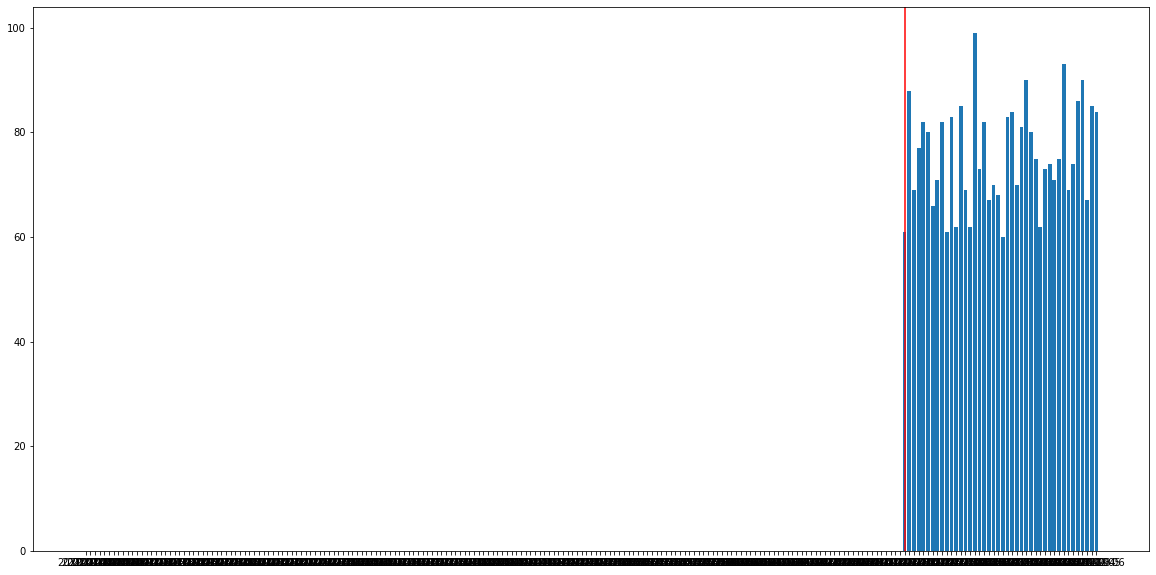

In [15]:
plt.figure(figsize=(20, 10))
plt.bar(count_added.index, height=count_added["eccentricity_count_added"])
plt.axvline(x = "2020-07-19", color = 'r')
plt.show()

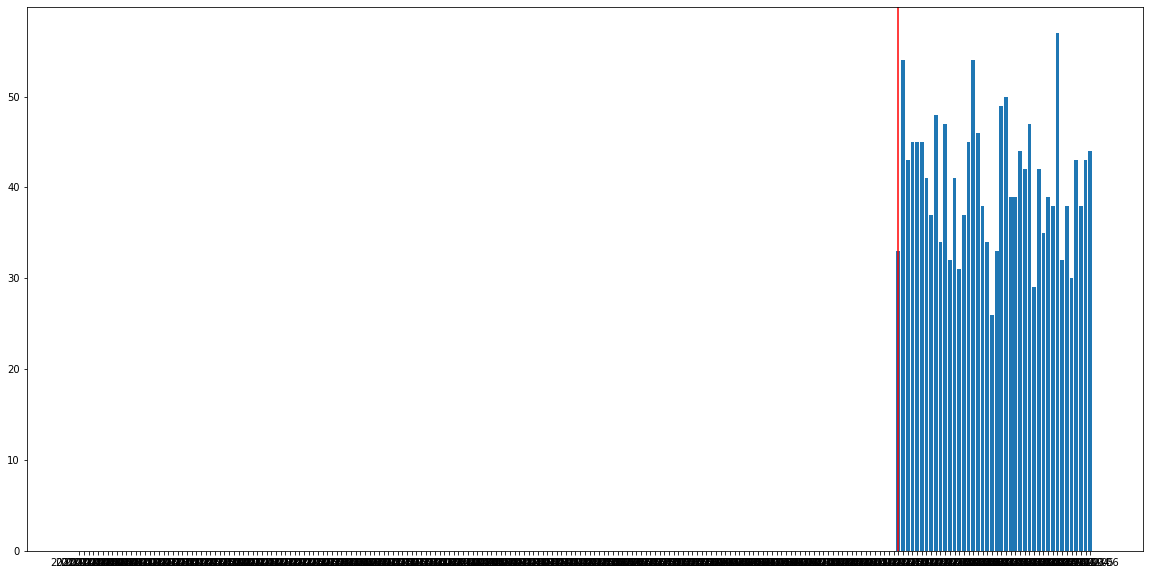

In [16]:
plt.figure(figsize=(20, 10))
plt.bar(count_added.index, height=count_added["atmosphere_count_added"])
plt.axvline(x = "2020-07-19", color = 'r')
plt.show()

## 3. An additional table

Now, we want to involve another table in our DB. `HABITABLES` records information about the habitability of exoplanets we've discovered. This table takes data from `EXOPLANETS` and other upstream tables and transforms it to produce a `habitability` index: a real number between 0 and 1 indicating how likely the planet is to harbor life.

In [17]:
c.execute("PRAGMA table_info(HABITABLES);")
c.fetchall()

[(0, '_id', 'TEXT', 0, None, 0),
 (1, 'perihelion', 'REAL', 0, None, 0),
 (2, 'aphelion', 'REAL', 0, None, 0),
 (3, 'atmosphere', 'TEXT', 0, None, 0),
 (4, 'habitability', 'REAL', 0, None, 0),
 (5, 'min_temp', 'REAL', 0, None, 0),
 (6, 'max_temp', 'REAL', 0, None, 0),
 (7, 'date_added', 'TEXT', 0, None, 0)]

In [18]:
pd.read_sql_query("SELECT * FROM HABITABLES LIMIT 10", conn)

,_id,perihelion,aphelion,atmosphere,habitability,min_temp,max_temp,date_added
0,c168b188-ef0c-4d6a-8cb2-f473d4154bdb,None,None,None,0.291440,NaN,NaN,2020-01-01
1,e7b56e84-41f4-4e62-b078-01b076cea369,None,None,None,0.835647,NaN,NaN,2020-01-01
2,a27030a0-e4b4-4bd7-8d24-5435ed86b395,None,None,None,0.894001,NaN,NaN,2020-01-01
3,54f9cf85-eae9-4f29-b665-855357a14375,None,None,None,0.415902,103.713749,560.180947,2020-01-01
4,4d06ec88-f5c8-4d03-91ef-7493a12cd89e,None,None,None,0.593524,NaN,NaN,2020-01-01
5,e16250b8-2d9d-49f3-aaef-58eed9a8864c,None,None,None,0.392487,119.300295,287.365651,2020-01-01
6,a0a6bf97-90d5-4686-8ccb-10753f8d335e,None,None,None,0.354851,219.467658,463.261262,2020-01-01
7,b28b4e19-8517-4ab5-97f0-c445f1aae6c4,None,None,None,0.518242,294.097443,464.827688,2020-01-01
8,7e34e44e-663f-491c-96c5-bb5acb8d5f1e,None,None,None,0.202482,107.737755,326.815526,2020-01-01
9,305e8ea0-663b-4311-b6b3-4198c051c335,None,None,None,0.426799,NaN,NaN,2020-01-01


## 4. Exercise: Visualizing Distribution Errors
Like in exercise 1, I'll write a quick query assessing a **distributional** feature of the `HABITABILITY` table -- how habitable is the average planet we detect, as a function of the day it was detected?

In [19]:
SQL = """
SELECT
    DATE_ADDED,
    AVG(habitability) AS avg_habitability
FROM
    HABITABLES
GROUP BY
    DATE_ADDED
"""

In [20]:
avg_habitability = pd.read_sql_query(SQL, conn)
avg_habitability = avg_habitability \
    .rename(columns={clmn: clmn.lower() for clmn in avg_habitability.columns})
avg_habitability = avg_habitability.set_index("date_added")

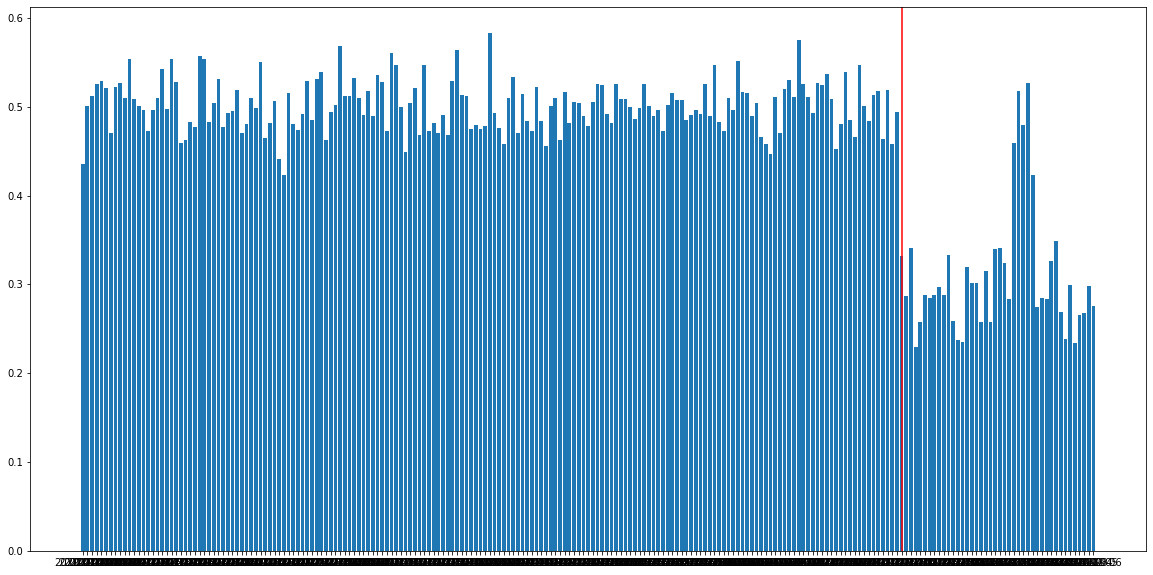

In [21]:
plt.figure(figsize=(20, 10))
plt.bar(avg_habitability.index, height=avg_habitability["avg_habitability"])
plt.axvline(x = "2020-07-19", color = 'r')
plt.show()

I plotted the date of the schema change, 2020-07-19, in red as a visual aid. Clearly, unless our instruments are malfunctioning, something is wrong! The planets we're adding to the table *after* the schema change seem much less habitable on average. Using a `SQL` query below, see if you can figure out what exactly.

*Hint*: When averages change, it's natural to look for occurrences of unusual values. When is `habitability` NULL, 0, or outside of the range $[0, 1]$? What about other fields in the table that might be related? Try writing a query that detects anomalous rates of such unusual values.

In [22]:
# YOUR CODE HERE
SQL = """
SELECT
    DATE_ADDED,
    CAST(SUM(CASE WHEN HABITABILITY IS 0 THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS HABITABILITY_ZERO_RATE
FROM
    HABITABLES
GROUP BY
    DATE_ADDED
"""
# END YOUR CODE

In [23]:
habitability_zero_rate = pd.read_sql_query(SQL, conn)
habitability_zero_rate = habitability_zero_rate \
    .rename(columns={clmn: clmn.lower() for clmn in habitability_zero_rate.columns})
habitability_zero_rate = habitability_zero_rate.set_index("date_added")

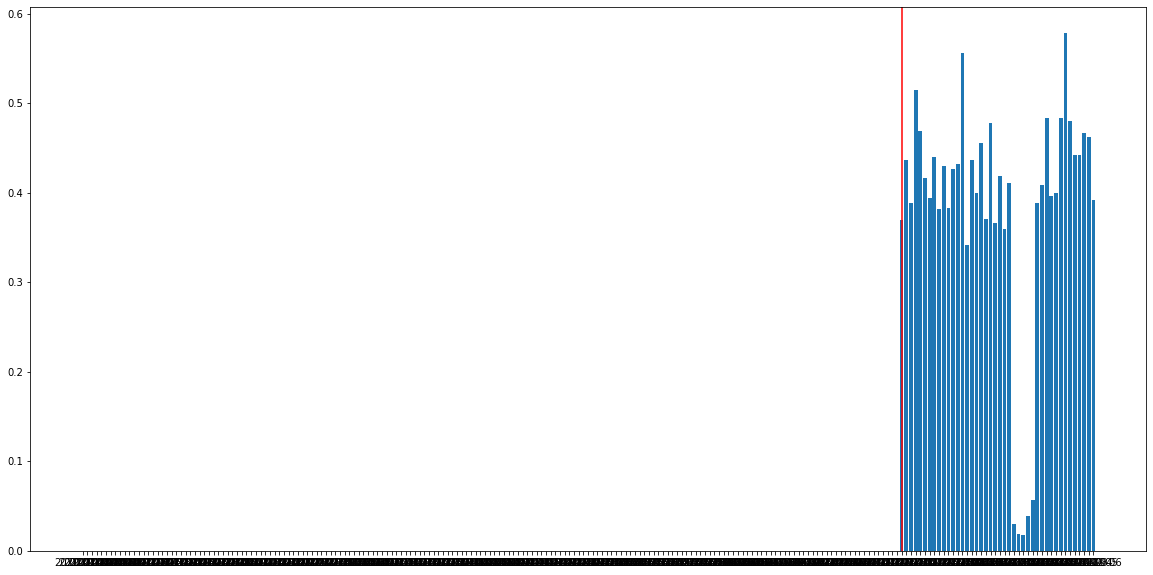

In [24]:
plt.figure(figsize=(20, 10))
plt.bar(habitability_zero_rate.index, height=habitability_zero_rate["habitability_zero_rate"])
plt.axvline(x = "2020-07-19", color = 'r')
plt.show()

With a small amount of digging, we can uncover something important -- the `habitability` index is never exactly 0 *before* the schema change, but afterwards we see the rate of 0s jump up to ~50%. This has the detected effect of dipping the average value of the field.

Note that in practice, you should look for both -- measuring a field's **rate of zero values**, as well as it's **average value**, can both help with identifying data downtime issues. As we saw last exercise, the **rate of null values** can also be helpful.

# Great work!

In the next exercise, we'll look at queries that span multiple tables, another step towards building intelligent data downtime systems.